In [45]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns


In [46]:
# Lista de clases en orden (según tus datos)
clases = sorted(list(set(y)))  # o pon las clases a mano si quieres orden específico

def plot_confusion(y_true, y_pred, modelo_nombre):
    cm = confusion_matrix(y_true, y_pred, labels=clases)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=clases, yticklabels=clases)
    plt.title(f"Matriz de Confusión - {modelo_nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

HOG (Histogram of Oriented Gradients) es una técnica muy útil para capturar la forma y bordes de un objeto

In [30]:
# Ruta relativa al dataset
base_path = "Dataset"  # Asegúrate de estar en el nivel correcto

In [31]:
features = []
labels = []

In [32]:
# Parámetros HOG
hog_params = {
    "orientations": 9,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "block_norm": 'L2-Hys'
}



1. Orientations = 9
Es el número de ángulos diferentes (bins) para construir el histograma de gradientes.
Divide el rango de 0° a 180° en 9 partes → cada bin cubre 20°.
Captura la dirección de los bordes.
Más orientations → más detalle angular (pero más costoso)

2. pixels_per_cell = (8, 8)
Cada celda del análisis contiene 8×8 píxeles.
Dentro de cada celda se calcula un histograma de gradientes orientados.
Tamaños más pequeños → mayor resolución espacial, pero más vectores.

3. cells_per_block = (2, 2)
Agrupa 2×2 celdas adyacentes en un bloque para normalizar la iluminación.
Es decir: 2×2 celdas de 8×8 píxeles → un bloque de 16×16 píxeles.
Normalización entre bloques mejora robustez frente a sombras o luz.

4. block_norm = 'L2-Hys'
Es el método de normalización de los histogramas en cada bloque.
'L2-Hys' = L2-norm con limitación (truncamiento) de valores extremos.
Mejora la robustez frente a cambios de iluminación o contraste.

In [ ]:
# Recorremos todas las carpetas de clases
for folder in os.listdir(base_path):
    class_path = os.path.join(base_path, folder)

    for file in os.listdir(class_path):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(class_path, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"No se pudo cargar: {img_path}")
            continue

        img = cv2.resize(img, (128, 128))  # Normaliza tamaño
        hog_feature = hog(img, **hog_params)
        features.append(hog_feature)
        labels.append(folder)  # Usa el nombre de la carpeta como clase


In [36]:
# Convertimos a arrays
X = np.array(features)
y = np.array(labels)

In [37]:
# Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [40]:
modelos = {
    "SVM": SVC(kernel='linear'),
    "Árbol": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}


 Entrenando modelo: SVM
                  precision    recall  f1-score   support

     Anthracnose       0.69      0.69      0.69       100
Bacterial Canker       0.83      0.91      0.87       100
  Cutting Weevil       0.97      0.98      0.98       100
        Die Back       0.92      0.90      0.91       100
      Gall Midge       0.69      0.73      0.71       100
         Healthy       0.79      0.82      0.80       100
  Powdery Mildew       0.80      0.77      0.79       100
     Sooty Mould       0.65      0.56      0.60       100

        accuracy                           0.80       800
       macro avg       0.79      0.79      0.79       800
    weighted avg       0.79      0.80      0.79       800



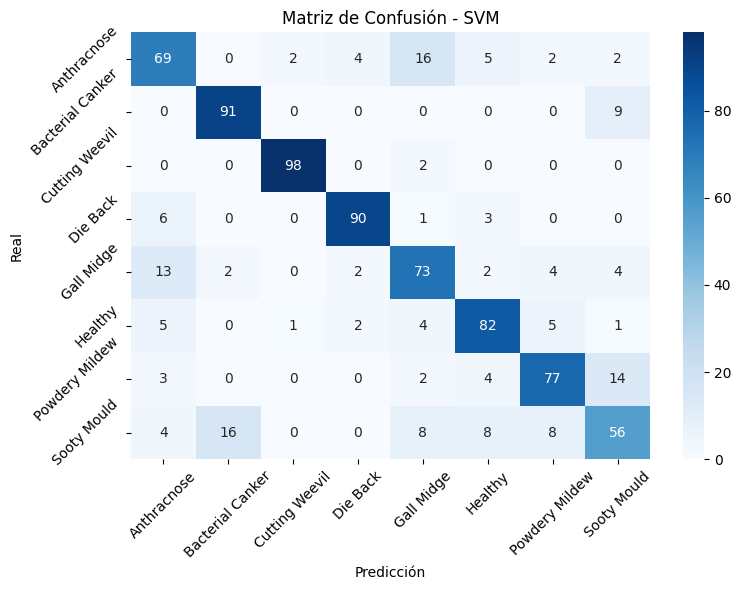


 Entrenando modelo: Árbol
                  precision    recall  f1-score   support

     Anthracnose       0.31      0.32      0.32       100
Bacterial Canker       0.71      0.65      0.68       100
  Cutting Weevil       0.71      0.81      0.76       100
        Die Back       0.54      0.48      0.51       100
      Gall Midge       0.29      0.32      0.31       100
         Healthy       0.25      0.25      0.25       100
  Powdery Mildew       0.43      0.45      0.44       100
     Sooty Mould       0.37      0.34      0.35       100

        accuracy                           0.45       800
       macro avg       0.45      0.45      0.45       800
    weighted avg       0.45      0.45      0.45       800



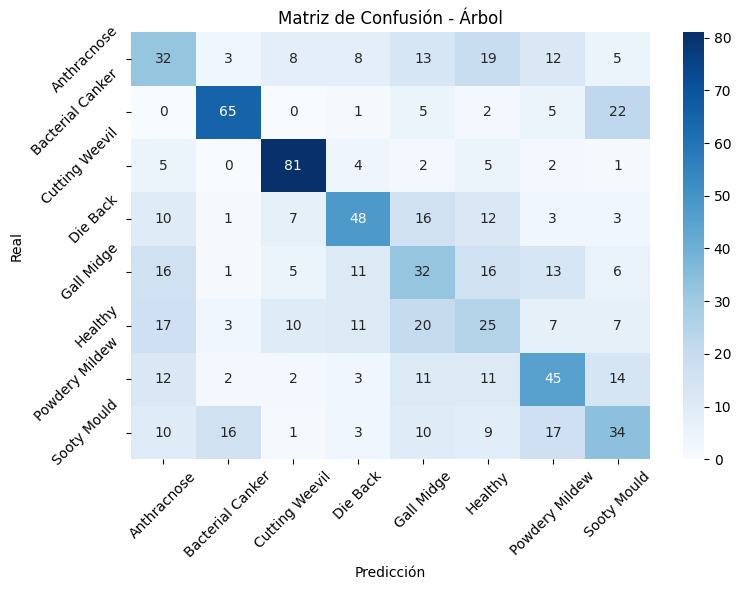


 Entrenando modelo: KNN
                  precision    recall  f1-score   support

     Anthracnose       0.62      0.56      0.59       100
Bacterial Canker       0.54      1.00      0.70       100
  Cutting Weevil       1.00      0.70      0.82       100
        Die Back       0.81      0.93      0.87       100
      Gall Midge       0.70      0.74      0.72       100
         Healthy       0.88      0.49      0.63       100
  Powdery Mildew       0.69      0.76      0.72       100
     Sooty Mould       0.69      0.47      0.56       100

        accuracy                           0.71       800
       macro avg       0.74      0.71      0.70       800
    weighted avg       0.74      0.71      0.70       800



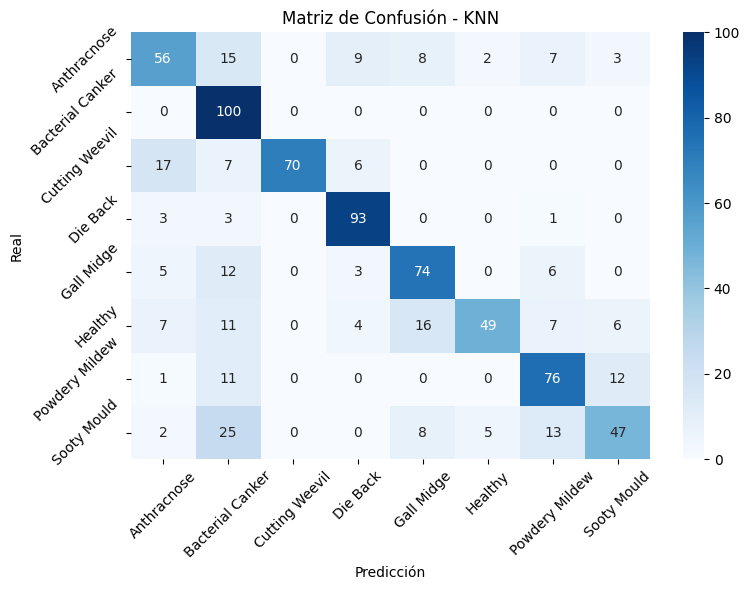


 Comparación de F1-score macro:
SVM: 0.7932
Árbol: 0.4519
KNN: 0.7012

 El mejor modelo según F1-score macro es: SVM


In [ ]:
# 4. Evaluación
resultados = {}

for nombre, modelo in modelos.items():
    print(f"\n Entrenando modelo: {nombre}")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='macro') #se usa macro para Promediar el F1-score de cada clase, sin ponderar.
    #Se calcula el F1 de cada clase individualmente.
    #Luego se hace un promedio simple de esos F1.
    #Así, todas las clases pesan igual, aunque unas tengan más datos que otras.
    resultados[nombre] = f1

    print(classification_report(y_test, y_pred))
    plot_confusion(y_test, y_pred, modelo_nombre=nombre)

# 5. Comparación final
print("\n Comparación de F1-score macro:")
for modelo, f1 in resultados.items():
    print(f"{modelo}: {f1:.4f}")

mejor = max(resultados, key=resultados.get)
print(f"\n El mejor modelo según F1-score macro es: {mejor}")